In [ ]:
%pip install jax
import jax.numpy as jnp
from jax.scipy.linalg import cholesky
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import seaborn as sns
from jax.numpy.linalg import cholesky
from jax.scipy.linalg import inv
from scipy.stats import multivariate_normal
import jax
import pandas as pd
from scipy.stats import multivariate_normal
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import torch
dist = torch.distributions

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
def make_contour_plot(x1,x2,p,ax):
  contour=ax.contourf(x1,x2,p)
  ax.view_init(90,90)
  ax.set_ylim([-8, 8])
  ax.set_xlim([-8, 8])
  ax.set_xlabel("$x_1$")
  ax.set_ylabel("$x_2$")
  sns.despine()
  return contour


In [ ]:
def make_pdf_2d_gaussian(X,Y,Z,ax):
    ax.plot_surface(X, Y, Z,cmap='viridis',linewidth=0)
    ax.set_xlabel('$x{_1}$')
    ax.set_ylabel('$x{_2}$')
    ax.set_xlim([-8,8])
    ax.set_xlim([-8,8])

In [ ]:
xyrange = jnp.array([[-8, 8], [-8, 8]])
npoints = 50j

In [ ]:
from ipywidgets import interact
@interact(mu1 =(-5.0,5.0),mu2=(-5.0,5.0),var1=(0.0,10.0),var2=(0.0,10.0),cov=(-5.0,5.0))
def plot(mu1=0.0,mu2=0.0, var1=3.0, var2=1.0, cov=0.0):
    figure,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(15,5),subplot_kw={'projection': "3d"})
    mu = jnp.array([mu1, mu2])
    sigma = jnp.array([[var1, cov],
             [cov, var2]])
    mesh = jnp.mgrid[xyrange[0, 0] : xyrange[0, 1] : npoints, xyrange[1, 0] : xyrange[1, 1] : npoints]
    x1, x2 = mesh[0], mesh[1]
    points = jnp.vstack([jnp.ravel(x1), jnp.ravel(x2)]).T
    distribution = multivariate_normal.pdf(points, mean=mu, cov=sigma).reshape(x1.shape[0], x2.shape[0])
    contour = make_contour_plot(x1,x2,distribution,ax2)
    figure.colorbar(contour)
    data = jax.random.multivariate_normal(mean = mu, cov = sigma, key=jax.random.PRNGKey(42),shape=(1000,))
    ax1.scatter(data[:,0],data[:,1])
    ax3.contour(x1,x2,distribution, zdir='y',offset=7.5 )
    ax3.contour(x1,x2,distribution, zdir='x' ,offset=-7.5)
    ax1.contour(x1,x2,distribution, zdir='y',offset=7.5 )
    ax1.contour(x1,x2,distribution, zdir='x' ,offset=-7.5)
    ax1.contour(x1,x2,distribution, zdir='z' )
    ax1.set_xlabel('$x_1$')
    ax1.set_ylabel('$x_2$')
    make_pdf_2d_gaussian(x1,x2,distribution,ax3)
    


interactive(children=(FloatSlider(value=0.0, description='mu1', max=5.0, min=-5.0), FloatSlider(value=0.0, des…

In [ ]:
mu=torch.Tensor([1,0])
cov =torch.Tensor([[6.0, 0.5], [0.5, 2.0]])

In [ ]:
n_samples=1000

In [ ]:
mvn = dist.MultivariateNormal(
    loc=mu, covariance_matrix=cov)
distribution = mvn.sample([n_samples])

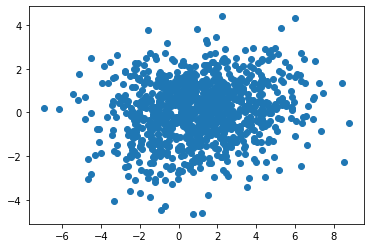

In [ ]:
data = pd.DataFrame(distribution,dtype=float)
plt.scatter(data.iloc[:,0],data.iloc[:,1])

### MLE for MVN

\begin{equation}
\begin{aligned}
&\hat{\mu}=\frac{1}{n} \sum_{i=0}^{n-1} \mathbf{x}^{(\mathbf{i})}=\overline{\mathbf{x}} \\
&\hat{\Sigma}=\frac{1}{n} \sum_{i=0}^{n-1}\left(\mathbf{x}^{(\mathbf{i})}-\hat{\mu}\right)\left(\mathbf{x}^{(\mathbf{i})}-\hat{\mu}\right)^{T}
\end{aligned}
\end{equation}


In [ ]:
center_data = data - data.mean()
mu_mle1,cov_mle1 = data.mean(),1/n_samples*jnp.dot(center_data.values.T,center_data.values)

In [ ]:
loc = torch.tensor([2, 5.0], requires_grad=True)
tril = torch.autograd.Variable(torch.tril(torch.ones(2, 2)), requires_grad=True)
opt = torch.optim.Adam([loc, tril], lr=0.1)

for i in range(250):
    to_learn = dist.MultivariateNormal(loc=loc, covariance_matrix=tril @ tril.t())
    loss = -torch.sum(to_learn.log_prob(distribution))
    loss.backward()
    if i % 50 == 0:
        print(f"I {i}, Loss: {loss.item():0.4f}")
    opt.step()
    opt.zero_grad()

I 0, Loss: 16693.3711
I 50, Loss: 4800.7217
I 100, Loss: 4501.7725
I 150, Loss: 4138.3545
I 200, Loss: 4046.1348


In [ ]:
mu_mle_grad,cov_mle_grad = to_learn.loc, to_learn.covariance_matrix

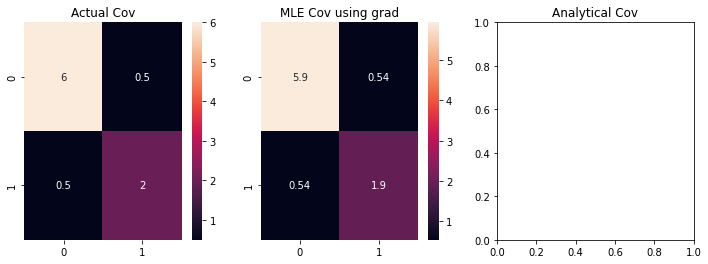

In [ ]:
fig,(ax1,ax2,ax3)=plt.subplots(1,3,figsize=(12,4))
sns.heatmap(cov, ax=ax1,annot=True)
sns.heatmap(cov_mle_grad.detach().numpy(), ax=ax2,annot=True)
# sns.heatmap(cov_mle1, ax=ax3,annot=True)
ax2.title.set_text('MLE Cov using grad')
ax1.title.set_text('Actual Cov')
ax3.title.set_text('Analytical Cov')

In [ ]:
cov_mle1

DeviceArray([[5.9452   , 0.5355799],
             [0.5355799, 1.929578 ]], dtype=float32)

In [ ]:
mu

tensor([1., 0.])

In [ ]:
mu_mle1

0    1.067180
1    0.055693
dtype: float64

In [ ]:
format(float(str(mu_mle_grad.detach().numpy()[0])), 'f'),format(float(str(mu_mle_grad.detach().numpy()[1])), 'f')

('1.068582', '0.055139')

(-6.0, 5.0)

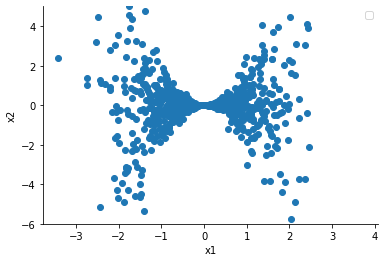

In [ ]:
corr_mvn = dist.MultivariateNormal(
    loc=torch.Tensor([0,0]), covariance_matrix=torch.Tensor([[1,0],[0,1]]))
distributionx= corr_mvn.sample([n_samples])
data1 = pd.DataFrame(distributionx,dtype=float)
corr = jnp.corrcoef(data1.iloc[:,0].values,data1.iloc[:,0].values**2*data1.iloc[:,1].values)
plt.scatter(data1.iloc[:,0],data1.iloc[:,0].values**2*data1.iloc[:,1])
sns.despine()
plt.xlabel('x1')
plt.ylabel('x2')
# plt.plot(data1.iloc[:,0],data1.iloc[:,0]*corr[0][1],color='black',label='y=x1*corr')
plt.legend()
plt.ylim([-6,5])

In [ ]:
corr

DeviceArray([[0.9999999 , 0.04185474],
             [0.04185474, 1.        ]], dtype=float32)